<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Paper%20Replicating/Pytorch_Paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Project 2: Pytorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research
paper into usable code.

## 0. Get setup

Let's import code previously written and libraries.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The goal here, is replicate the ViT architecture for our FoodVision Mini Problem

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
import os
from going_modular.going_modular import data_setup
from torchvision import transforms

#Create image size
IMG_SIZE = 224 # Comes from table 3 of the ViT paper

manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor(),
])

print(f"Manually crated transforms {manual_transforms}")

Manually crated transforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Creating dataloaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=BATCH_SIZE,
                                                                    num_workers=os.cpu_count())

len(train_dataloader), len(test_dataloader), class_names
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b00fc9f1190>,
 ['pizza', 'steak', 'sushi'])

### 2.3 VIsualize a single image

As always, let's adhere to the motto, visualize, visualize!

In [9]:
# Get a batch of images

image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

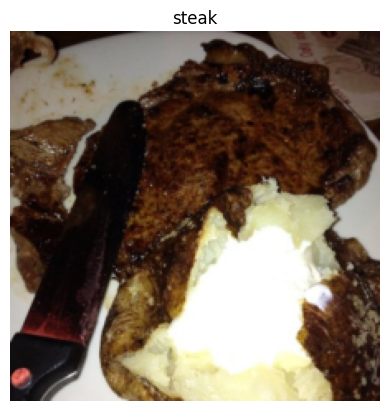

In [10]:
# Plot the image with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview
Before we write any more code, let's discuss what we're doing.

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our model inputs are: images of pizza, steak and sushi.

And our ideal model outputs are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

## 4. Equation 1: Split daa into patches and creating the class, position and patch embedding

 Layers = input -> function -> output

 What's the input shape?

 What's the output shape?

 * Input shape: (224, 224, 3) -> Single image (height, width, color channels)

 * Output shape: ${N \times\left(P^{2} \cdot C\right)}$
 * H = Heigth
 * W = Width
 * C = Color channels
 * P = Patch size
 * N = number of patches = (height * width) / p^2
 * D = constant latent vector size = embedding dimension

In [12]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [15]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f" Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

 Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)
